In [17]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib
from scipy.ndimage.measurements import label
from pydub import AudioSegment


/tmp/ipython-input-17-487757429.py:13: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


In [4]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/22:05:23/'

all_files = os.listdir(data_path)


audio_files = [os.path.join(data_path, f) for f in all_files if f.lower().endswith(('.wav', '.mp3', '.flac', '.ogg'))]

audio_files.sort()

audio_files = audio_files[-20:]

if not audio_files:
    print(f"No audio files found in {data_path}")
else:
    # Read the first audio file
    combined_audio = AudioSegment.from_file(audio_files[0])

    # Concatenate the rest of the audio files
    for audio_file in audio_files[1:]:
        try:
            next_audio = AudioSegment.from_file(audio_file)
            combined_audio += next_audio
        except Exception as e:
            print(f"Could not process file {audio_file}: {e}")

    # Export the combined audio to a new file (e.g., FLAC format)
    output_filename = "combined_audio.flac"
    try:
        combined_audio.export(output_filename, format="flac")
        print(f"Concatenated audio saved to {output_filename}")
    except Exception as e:
        print(f"Error during FLAC export, attempting with 'wav' intermediate format: {e}")
        try:
            # Export to WAV first, then potentially convert if needed (though FLAC export directly should work)
            # This is more of a diagnostic step or a potential workaround if the direct FLAC export fails due to size
            combined_audio.export("temp_combined_audio.wav", format="wav")
            print("Exported to temporary WAV. You may need to convert this to FLAC separately if the error persists.")
        except Exception as inner_e:
             print(f"Failed even exporting to WAV: {inner_e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Concatenated audio saved to combined_audio.flac


In [5]:
y, sr = librosa.load('combined_audio.flac', sr=44100, mono=False)
sop = y[0] - y[1]

In [6]:
def butter_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def pre_emphasize(signal, coeff=0.9459):
    return lfilter([1, -coeff], [1], signal)

sop_filtered = butter_filter(sop, 300, sr)
pre_emphasized_sop = pre_emphasize(sop_filtered)

In [19]:
mfccs = librosa.feature.mfcc(
    y=pre_emphasized_sop,
    sr=sr,
    n_mfcc=13,
    n_fft=int(sr * 0.02),
    hop_length=int(sr * 0.01),
    n_mels=30,
    window='hamming')

hop_length = int(sr * 0.01)  # for time conversion
mfccs = mfccs[1:, :].T  # remove 0th coeff, transpose to (frames, features)
scaler = StandardScaler()
mfccs_norm = scaler.fit_transform(mfccs)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [8]:
class MFCCDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=12, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataset = MFCCDataset(mfccs_norm)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [21]:
best_loss = float('inf')
epochs_no_improve = 0
for epoch in range(100):
    model.train()
    losses = []
    for batch in dataloader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epoch_loss = np.mean(losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 10:
            print("Early stopping.")
            break

Epoch 1, Loss: 0.0124
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0001
Epoch 4, Loss: 0.0001
Epoch 5, Loss: 0.0001
Epoch 6, Loss: 0.0001
Epoch 7, Loss: 0.0001
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001
Epoch 11, Loss: 0.0001
Epoch 12, Loss: 0.0001
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 16, Loss: 0.0001
Epoch 17, Loss: 0.0001
Epoch 18, Loss: 0.0001
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0001
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0001
Epoch 23, Loss: 0.0001
Epoch 24, Loss: 0.0001
Epoch 25, Loss: 0.0000
Epoch 26, Loss: 0.0000
Epoch 27, Loss: 0.0001
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0001
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.0000
Epoch 44, Loss: 0.00

In [22]:
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()
train_tensor = torch.FloatTensor(mfccs_norm)
with torch.no_grad():
    recon = model(train_tensor)
    errors = torch.mean((train_tensor - recon)**2, dim=1).numpy()

threshold = np.percentile(errors, 95)
print(f"Threshold for anomaly: {threshold:.4f}")

Threshold for anomaly: 0.0001


In [40]:
# 8. Inference on test audio
def process_audio_for_anomaly_detection(filepath):
    y, sr = librosa.load(filepath, sr=44100, mono=False)
    sop_test = pre_emphasize(butter_filter(y[0] - y[1], 300, sr))
    mfcc = librosa.feature.mfcc(y=sop_test, sr=sr, n_mfcc=13, n_fft=int(sr * 0.02), hop_length=int(sr * 0.01), n_mels=30)
    mfcc = mfcc[1:, :].T
    scaler = joblib.load('scaler.pkl')
    return scaler.transform(mfcc), sop_test


In [41]:
def smooth_errors(errors, window_size=5):
  return np.convolve(errors, np.ones(window_size)/window_size, mode='same')

mfcc_test, sop_test = process_audio_for_anomaly_detection('/content/drive/MyDrive/Fibre_shaking/output-20231101-123827.flac')
test_tensor = torch.FloatTensor(mfcc_test)
with torch.no_grad():
  recon_test = model(test_tensor)
  errors_test = torch.mean((test_tensor - recon_test)**2, dim=1).numpy()

errors_test_smoothed = smooth_errors(errors_test, window_size=5)
anomalies = np.where(errors_test_smoothed > 1)[0]

In [42]:
def group_anomalies(anomaly_mask):
  labels, num = label(anomaly_mask)
  segments = []
  for i in range(1, num + 1):
    region = np.where(labels == i)[0]
    start_time = region[0] * hop_length / sr
    end_time = region[-1] * hop_length / sr
    segments.append((start_time, end_time))
  return segments

grouped_anomalies = group_anomalies(errors_test_smoothed > 1)
print("Detected anomalous segments (in seconds):")
for start, end in grouped_anomalies:
  print(f"- From {start:.2f}s to {end:.2f}s")

Detected anomalous segments (in seconds):
- From 3.85s to 3.90s
- From 60.98s to 61.00s


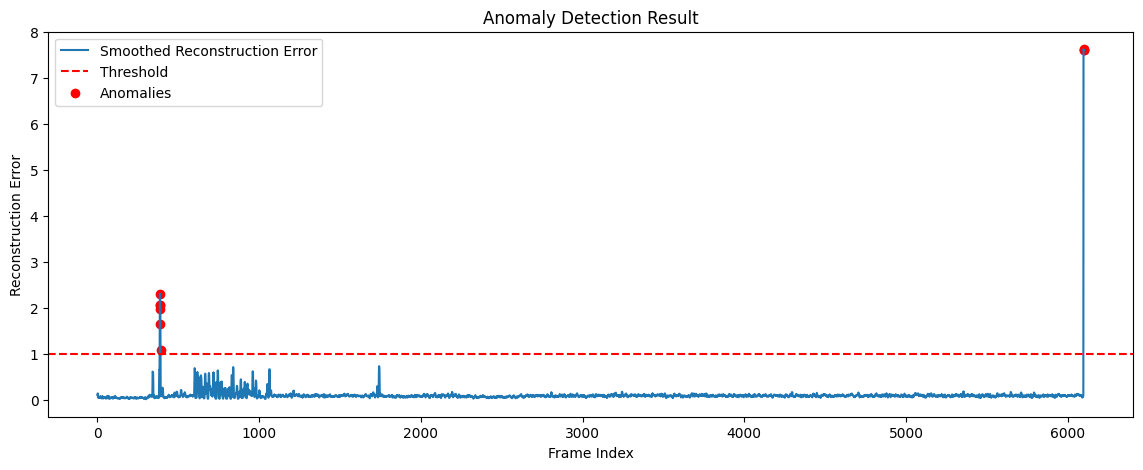

Detected 9 anomalous frames.


In [43]:
plt.figure(figsize=(14, 5))
plt.plot(errors_test_smoothed, label='Smoothed Reconstruction Error')
plt.axhline(1, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies, errors_test_smoothed[anomalies], color='red', label='Anomalies')
plt.title('Anomaly Detection Result')
plt.xlabel('Frame Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

print(f"Detected {len(anomalies)} anomalous frames.")

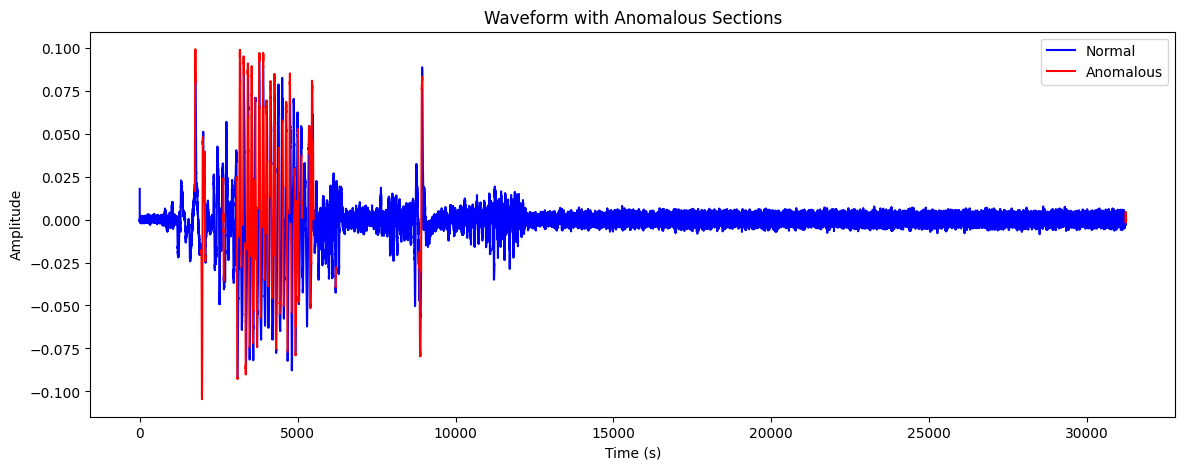

In [53]:
def plot_waveform_with_anomalies(y, sr, reconstruction_errors, threshold, frame_length, hop_length):
  """
    Plots the audio waveform highlighting sections with reconstruction error above a threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        threshold (float): The threshold for classifying a frame as anomalous.
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """
  plt.figure(figsize=(14, 5))
  # Use librosa.times_like to generate time vector based on signal length
  times_y = librosa.times_like(y, sr=sr)

  # Determine which frames are anomalous based on the threshold
  anomalous_frames_bool = reconstruction_errors > 0.19

  # Create an array to store the anomaly status for each sample
  sample_anomaly_status = np.zeros_like(y, dtype=bool)

  # Propagate frame anomaly status to samples within the frame's effective duration
  # A sample is considered anomalous if it falls within *any* frame that is marked as anomalous
  for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
    if is_anomalous_frame:
      # Calculate start sample of the frame
      start_sample = i * hop_length
      # The end sample should cover the entire window for that frame,
      # but we only need to mark samples up to the start of the next frame
      # or the end of the signal to avoid overlap issues in marking.
      # A simpler approach for visualization is to mark samples within the hop's duration for the anomalous frame.
      # Let's mark the samples from the hop start to the next hop start (or end of signal)
      end_sample = min((i + 1) * hop_length, len(y))
      sample_anomaly_status[start_sample:end_sample] = True


  # Split the waveform based on anomaly status
  normal_y = y.copy()
  anomalous_y = y.copy()

  normal_y[sample_anomaly_status] = np.nan
  anomalous_y[~sample_anomaly_status] = np.nan

  # Plot the normal parts
  # Ensure the time vector matches the y data length
  plt.plot(times_y, normal_y, color='blue', label='Normal')

  # Plot the anomalous parts
  # Ensure the time vector matches the y data length
  plt.plot(times_y, anomalous_y, color='red', label='Anomalous')


  plt.title('Waveform with Anomalous Sections')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude') # Added missing ylabel
  plt.legend()
  plt.show()


# Define frame_length (n_fft)
frame_length = int(sr * 0.02) # Assuming sr is the sampling rate from librosa.load used for sop_test
# Define hop_length
hop_length = int(sr * 0.01)

# Define the threshold used for smoothed errors
anomaly_threshold = 1 # This was the threshold used in the plt.axhline call for smoothed errors

# Call the function to plot the waveform with anomalies
plot_waveform_with_anomalies(
    y=sop_test,
    sr=sr,
    reconstruction_errors=errors_test_smoothed,
    threshold=anomaly_threshold,
    frame_length=frame_length,
    hop_length=hop_length
)

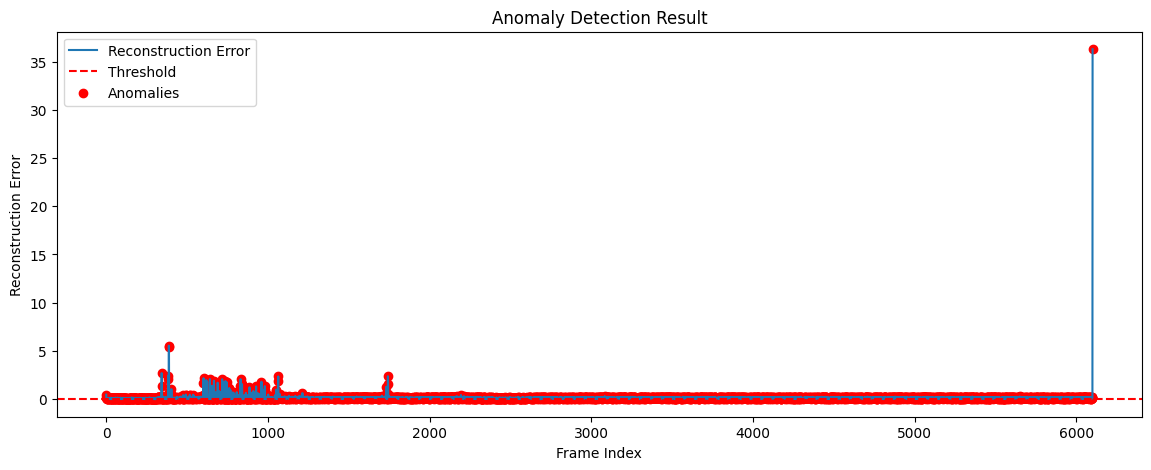

Detected 6101 anomalous frames.


In [13]:
# 9. Compute reconstruction error
mfcc_test = process_audio_for_anomaly_detection('/content/drive/MyDrive/Fibre_shaking/output-20231101-123827.flac')
test_tensor = torch.FloatTensor(mfcc_test)
with torch.no_grad():
    recon_test = model(test_tensor)
    errors_test = torch.mean((test_tensor - recon_test)**2, dim=1).numpy()

anomalies = np.where(errors_test > threshold)[0]
plt.figure(figsize=(14, 5))
plt.plot(errors_test, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies, errors_test[anomalies], color='red', label='Anomalies')
plt.title('Anomaly Detection Result')
plt.xlabel('Frame Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

print(f"Detected {len(anomalies)} anomalous frames.")